# Laser Diffraction fringe analysis

Using frequency domain analysis on laser diffraction data.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 17/05/2022
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia

In [85]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import os #glob, sys, os
import matplotlib.pyplot as plt
import scipy.integrate
import tqdm
#from scipy.interpolate import interp2d
#import scipy.integrate, scipy.signal
#from joblib import Parallel, delayed
%matplotlib notebook

## Load images

In [51]:
# Define where images come from.
source_images = "/Users/dduke/Desktop/ethanol_water"

# Read in images.
Iraw=ImageSequence(source_images, IO_threads=4, use_magick=False)

# Crop ROI
Iraw.crop(280,700,630,1115)

Reading /Users/dduke/Desktop/ethanol_water
	Found 141 images with extension .tif
	PIL thinks the bit depth is uint8
	Increasing stored bit depth from uint8 to <class 'numpy.uint16'>
	Reading files into memory...
4 tasks on 4 processors


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.1s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.1s finished


Read 176.2 MiB in 7.2 sec
	Data in memory:	 (141, 1024, 1280)
	Intensity range:	 0 to 255 	 uint16
	Array size:	352.5 MB


## Make a subset of the data for analysis

In [123]:
Ib = Iraw.arr[:, int(Iraw.height/2): ,:] # bottom half of beam
It = Iraw.arr[:, :int(Iraw.height/2) ,:] # top half of beam
If=Iraw.arr[...] # everything in the beam

# Pad with zeros to make square
#Ib = np.pad(Ib, ((0,0),(137,138),(0,0)))
#It = np.pad(It, ((0,0),(138,138),(0,0)))
#If = np.pad(If, ((0,0),(32,33),(0,0)))

# Pad more zeros
#Ib = np.pad(Ib, ((0,0),(13,13),(13,13)))
#It = np.pad(It, ((0,0),(13,13),(13,13)))
#If = np.pad(If, ((0,0),(13,13),(13,13)))

## Show sample image

<IPython.core.display.Javascript object>


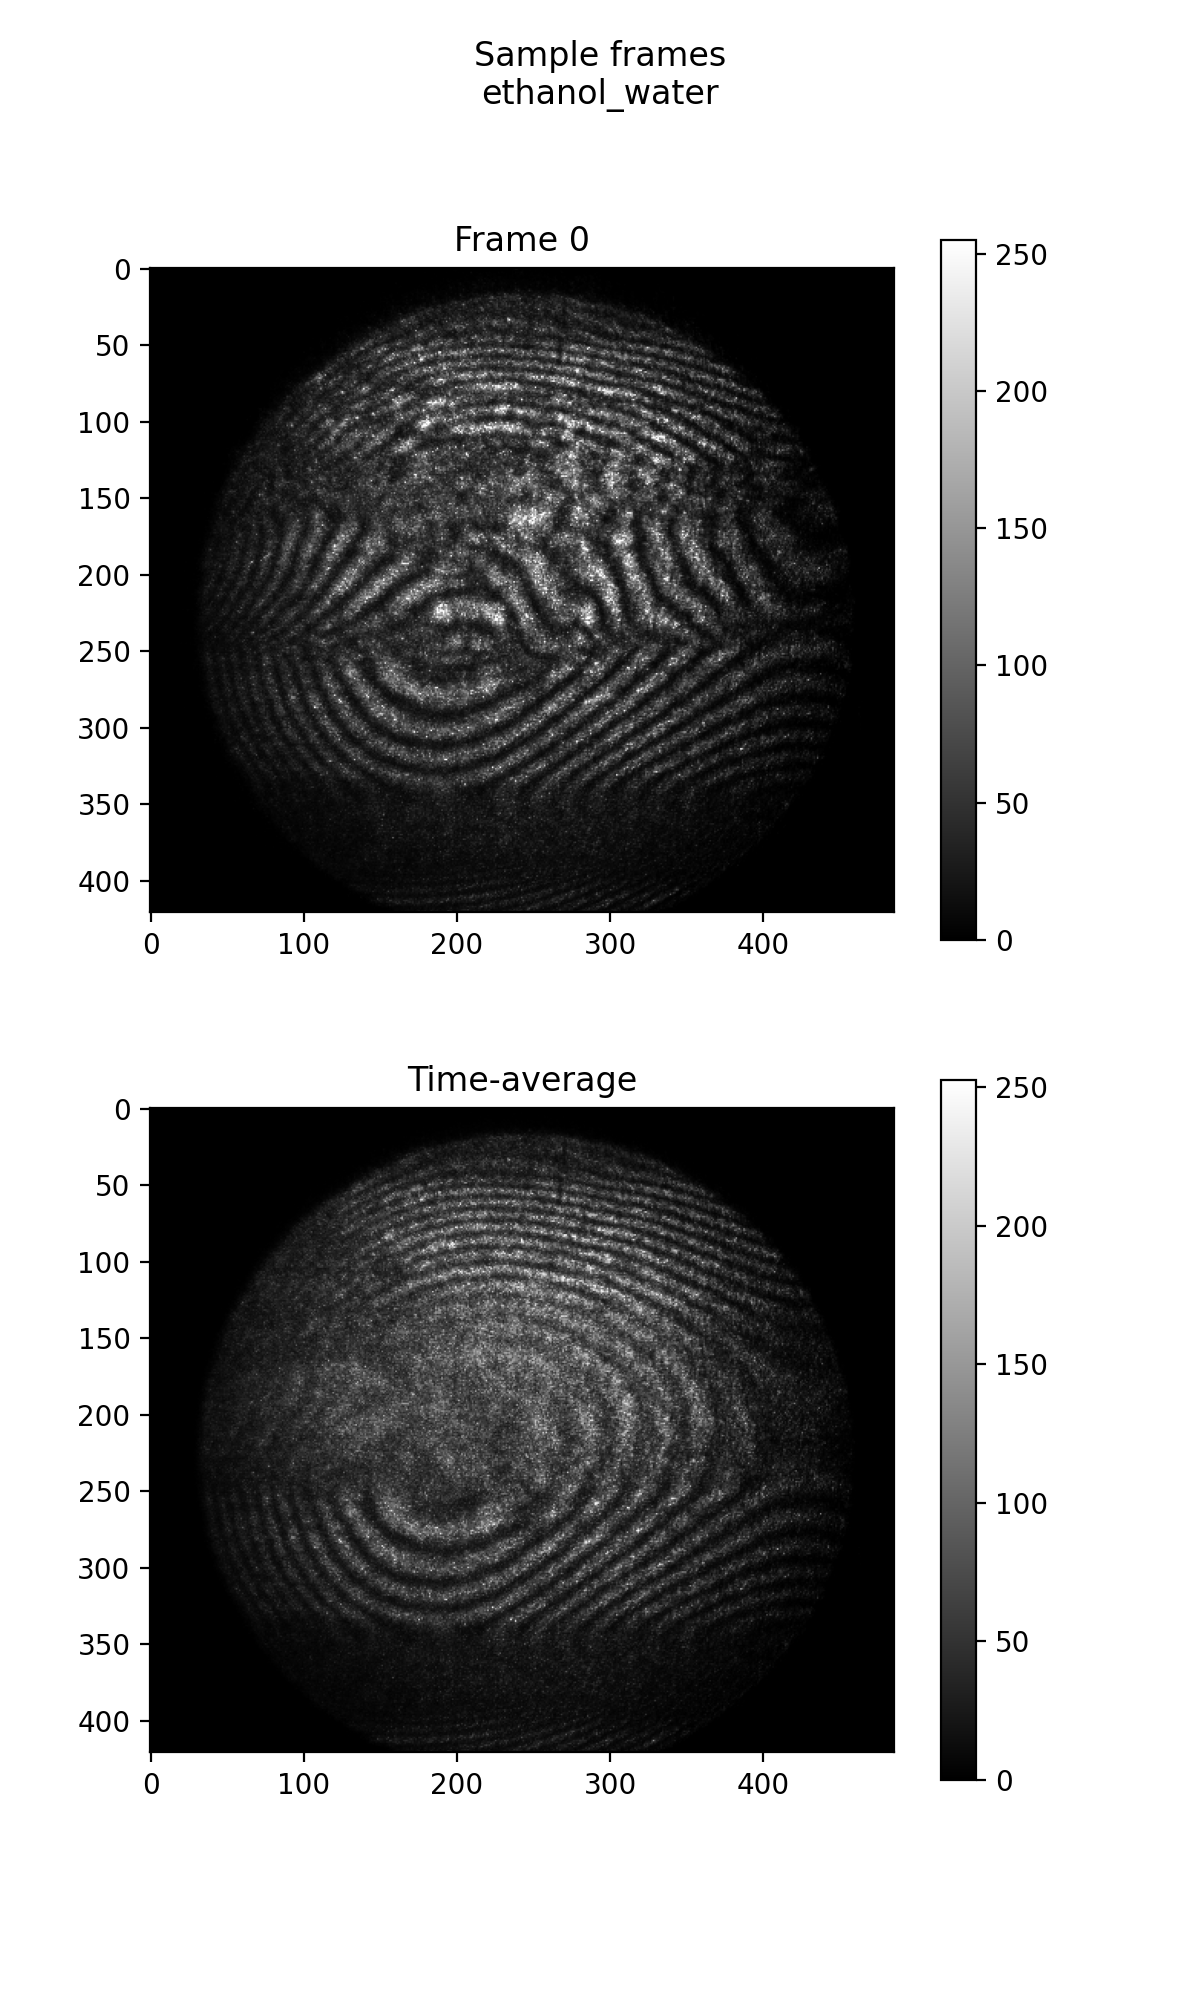

In [124]:
avg_img = np.nanmean(If,axis=0).astype(np.float64)

# Show some samples
fig=plt.figure(figsize=(6,10))
plt.suptitle("Sample frames\n"+os.path.basename(source_images))

ax=fig.add_subplot(211)
plt.title("Frame 0")
h=ax.imshow(If[0,...],cmap=plt.cm.gray)
plt.colorbar(h,ax=ax);

ax=fig.add_subplot(212)
plt.title("Time-average")
h=ax.imshow(avg_img,cmap=plt.cm.gray)
plt.colorbar(h,ax=ax);

## Apply Fourier Transform

In [127]:
HP_FILTER = 10

# Compute the 2D-FFT of every image and average them all.
avg_ffts=[]
for I in [If,Ib,It]: # Loop through different subsets of data.

    avg_fft=np.zeros(I.shape[1:],dtype=np.complex128)
    for n in tqdm.tqdm(range(I.shape[0])):
        img = I[n,...].astype(np.float64)
        #img -= np.nanmean(img)  # remove spatial avg.
        avg_fft+=np.fft.fft2(img) 
    avg_fft /= float(I.shape[0])
    
    # Filter out the low frequency data (near DC offset)
    l,w = avg_fft.shape
    y,x = np.meshgrid(np.arange(w),np.arange(l))
    r=np.sqrt((x-l/2)**2 + (y-w/2)**2)
    
    avg_ffts.append(avg_fft*np.fft.fftshift(r>HP_FILTER))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 224.39it/s]


<IPython.core.display.Javascript object>


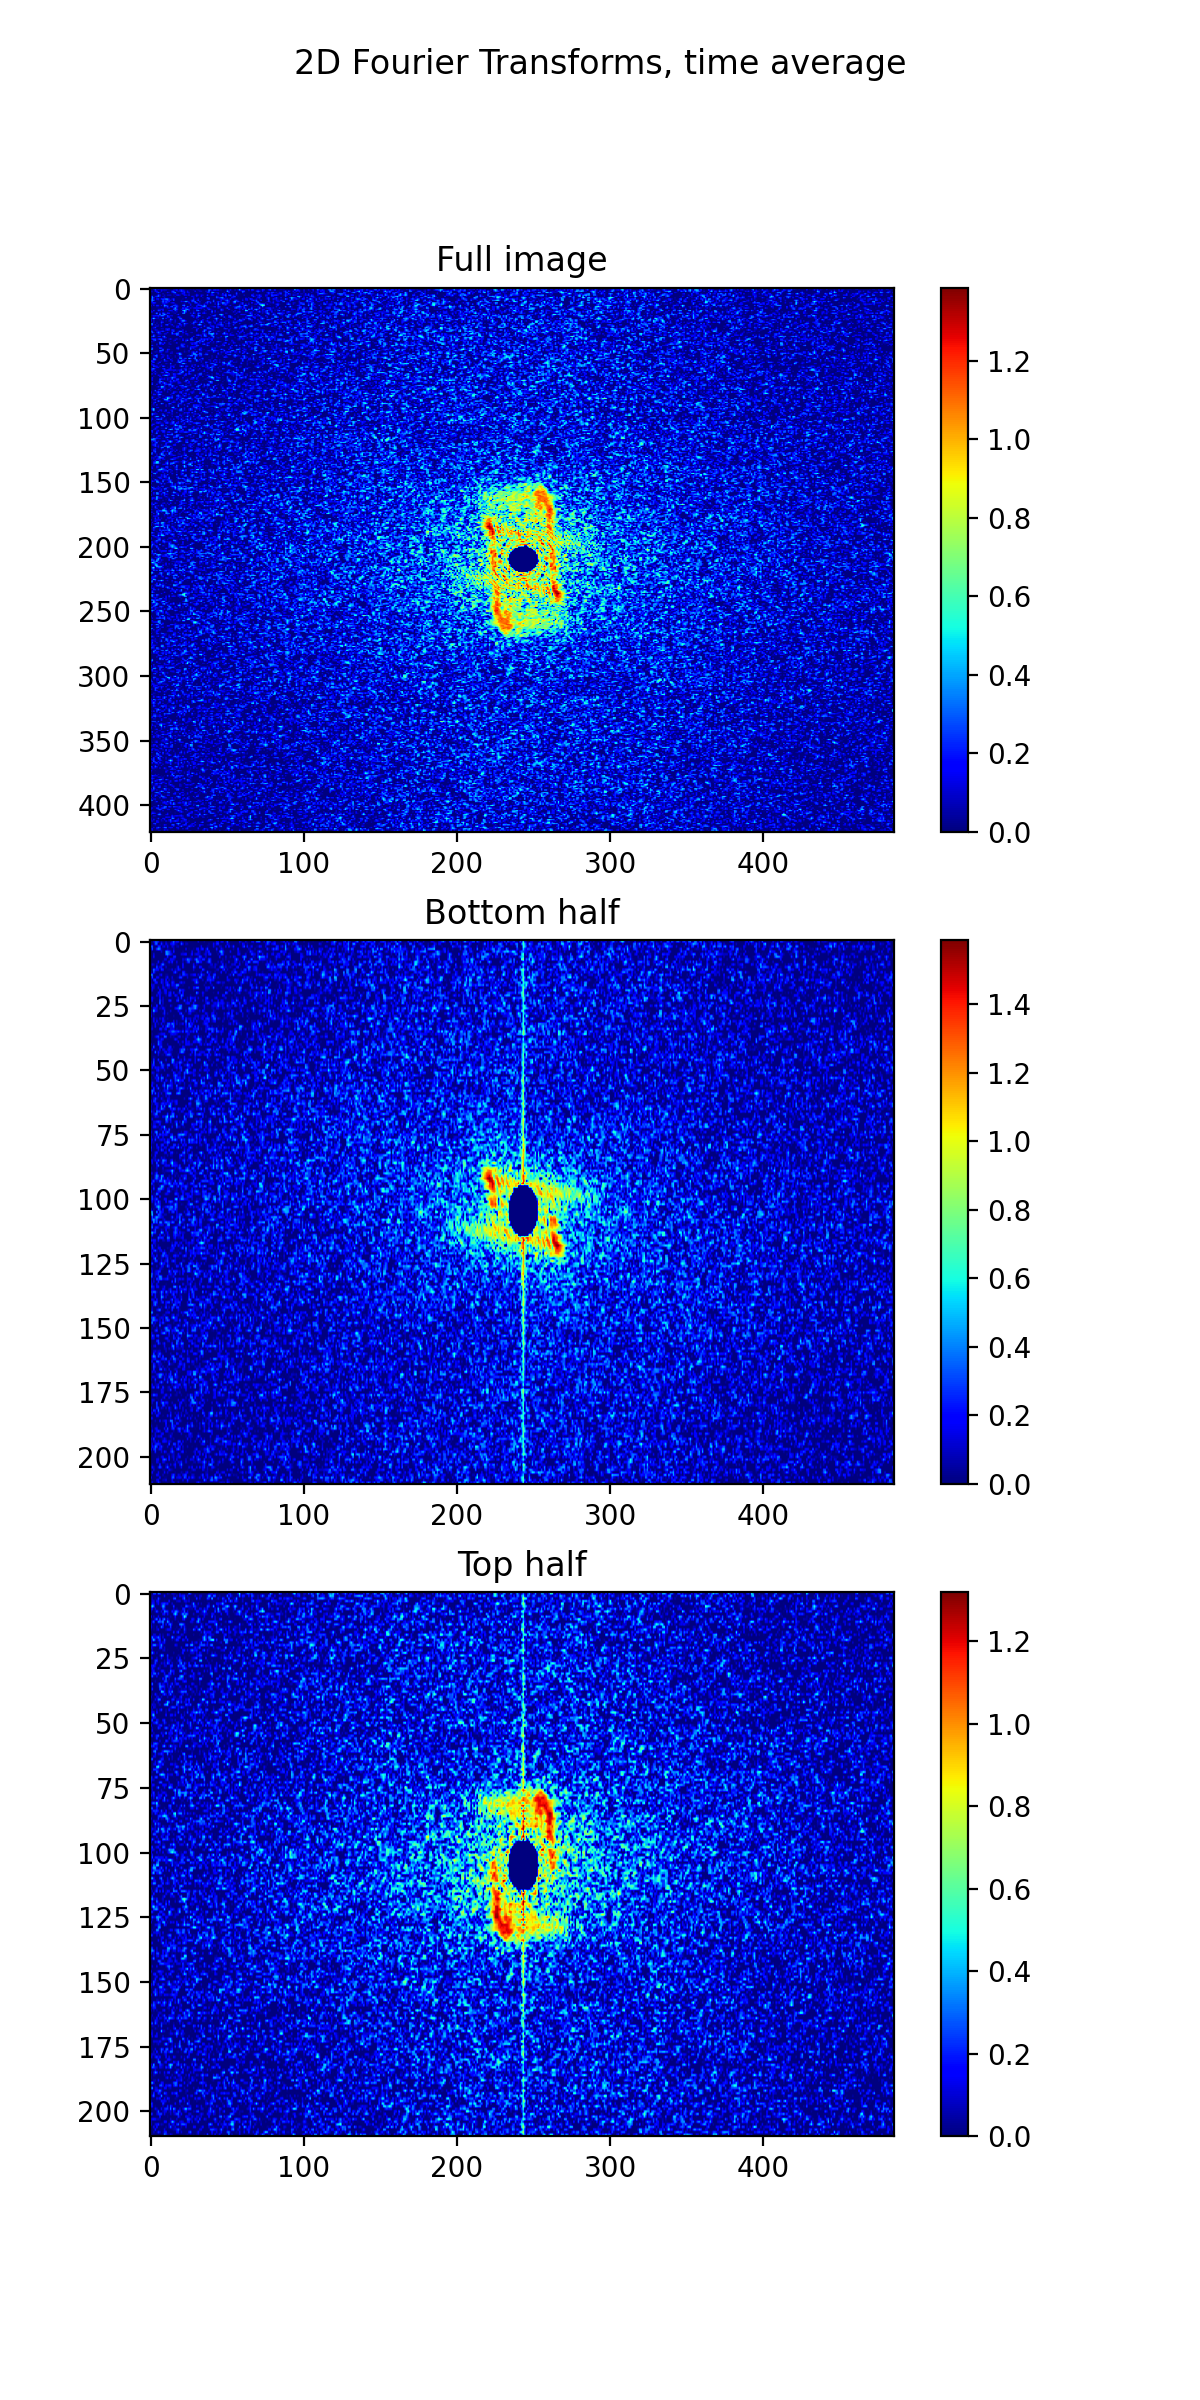

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_34520/23718541.py:11: RuntimeWarning: divide by zero encountered in log10
  plottable = np.log10( np.abs( np.fft.fftshift( avg_fft/flr )  )  )


In [128]:
# Prepare a plot
fig=plt.figure(figsize=(6,12))
plt.suptitle("2D Fourier Transforms, time average")
labels=["Full image","Bottom half","Top half"]
n=0
for avg_fft in avg_ffts:

    # Set the noise floor at higher frequencies to unity amplitude
    l,w = avg_fft.shape
    flr = np.nanmean(np.abs(avg_fft[int(l*2/5):int(l*3/5),int(w*2/5):int(w*3/5)]))
    plottable = np.log10( np.abs( np.fft.fftshift( avg_fft/flr )  )  )
    plottable[plottable<0]=0

    # Prepare a surface plot

    ax=fig.add_subplot(311+n)
    h=ax.imshow( plottable ,cmap=plt.cm.jet, aspect='auto')
    plt.colorbar(h,ax=ax)
    plt.title(labels[n])
    n+=1

<IPython.core.display.Javascript object>


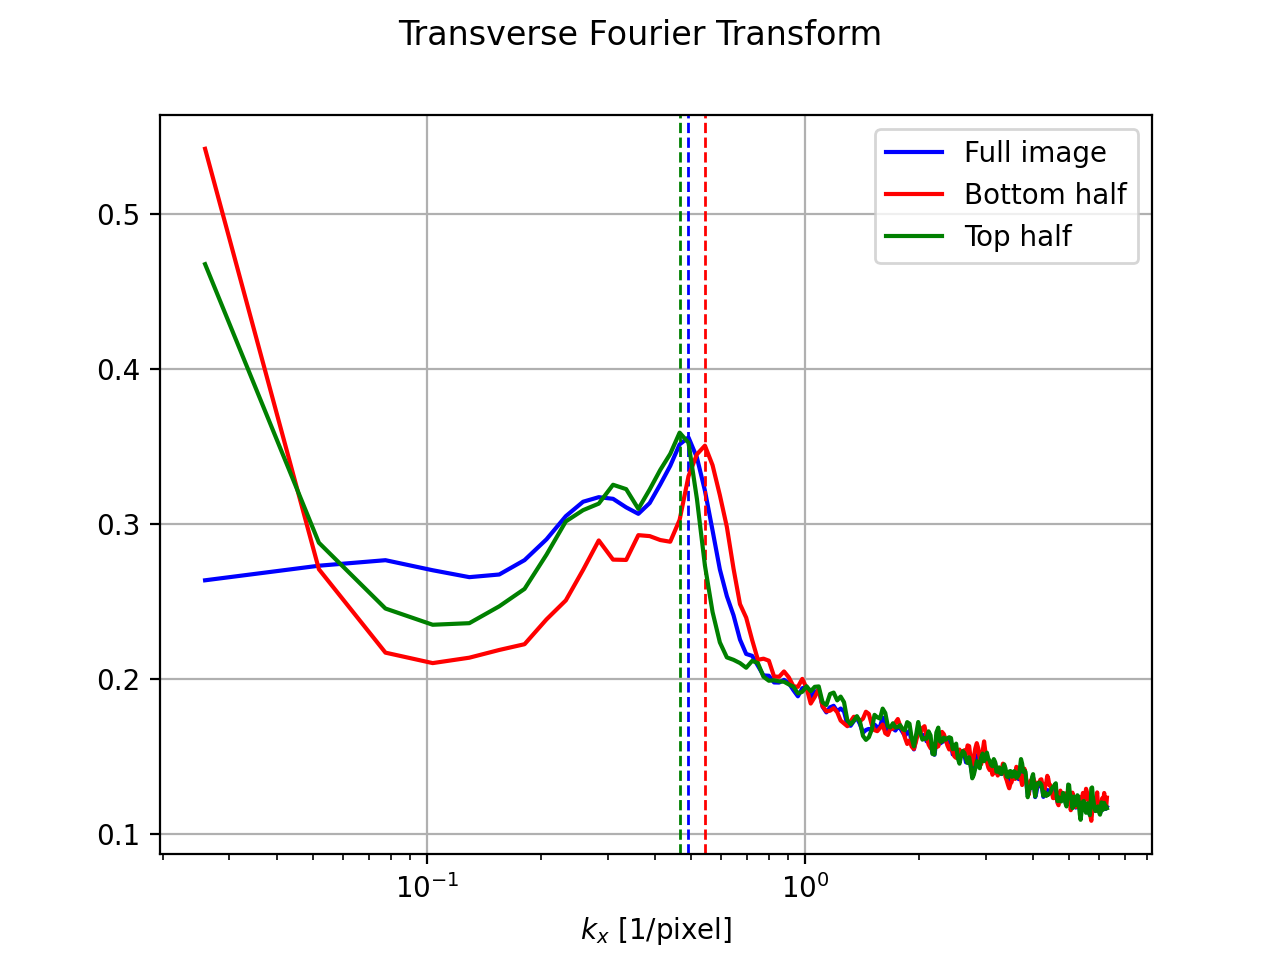

Full image
   - peak k_x = 0.491278 /px
   - peak wavelength = 12.789474 px
243 (141, 421, 486)
Bottom half
   - peak k_x = 0.542991 /px
   - peak wavelength = 11.571429 px
243 (141, 421, 486)
Top half
   - peak k_x = 0.465421 /px
   - peak wavelength = 13.500000 px
243 (141, 421, 486)


In [133]:
# Compute the vertically-integrated, transverse FFT amplitude.

fig=plt.figure()
plt.suptitle("Transverse Fourier Transform")
ax=fig.add_subplot(111)
plt.grid()
plt.xlabel(r"$k_x$ [1/pixel]")
colors=['b','r','g','k']
n=0

for avg_fft in avg_ffts:
    
    # Multiply by the filter condition
    # (the amplitude is arbitrary).
    vf = np.sum(np.abs(avg_fft),axis=0)

    # Fold the FFT back on itself to be single-sided
    vf = vf[:int(len(vf)/2)] + vf[-1:-int(len(vf)/2)-1:-1]

    # Compute the wavenumber range in 1/pixel
    # Note that len(vf) is half the domain so Nyquist criterion is already taken care of (max freq=half sample rate)
    kx = np.linspace(2*np.pi/len(vf),2*np.pi,len(vf))

    # Renormalize the FFT amplitude
    vf /= scipy.integrate.trapz(vf, x=kx)

    # Find peak away from low frequency region
    peak = np.where(vf[HP_FILTER:] == np.nanmax(vf[HP_FILTER:]))
    kx_peak = float(kx[peak[0]+HP_FILTER])

    print(labels[n])
    print("   - peak k_x = %f /px" % kx_peak)
    print("   - peak wavelength = %f px" % (2*np.pi/(kx_peak)))

    ax.semilogx(kx,vf,label=labels[n],c=colors[n])
    plt.axvline(kx_peak,lw=1,ls='--',c=colors[n])
    n+=1
    
plt.legend();
#plt.xlim(kx[HP_FILTER],);)